The Multivariate Covariance Generalized Linear Model (MCGLM) is a universalization of the classic statistical model GLM, widening for multivariate and non-independent response fitting. Due to its pliancy and explicit specification, this unified model can support many statistical analyses on a wide variety of data and distinct traits. Aiming to foment the pervasiveness of statistical analysis with MCGLM support, this essay instills MCGLM and its comprehensive new Python library - the `mcglm`. The library is hosted on PyPI and can be installed with the aid of some Python library manager, such as pip. https://pypi.org/project/mcglm/.


### Introduction

Dated at the beginning of the 19th century and controversial about actual authorship, the least squares method established an optimization proposal `[1]`. According to the Gauss-Markov theorem `[2]`, the resulting estimates are optimal and unbiased under linear conditions of continuous values. This optimization method is leveraged by `linear regression`, one of the primordial statistical models `[3]`, `[4]`. A linear regression associates a response variable to a group of covariates by employing a linear operation on regression parameters `[5]`. Three main assumptions for linear regression are linearity, independent realizations of the response variable, and a gaussian homoscedastic error with a zero mean. Aiming to generalize it, some subsequential statistical proposals expanded these assumptions.

The Generalized Linear Model (GLM) `[6]` generalizes the gaussian assumption of linear regression to some models of the exponential family `[7]`; The Generalized Additive Model (GAM) `[8]` manages regression by the sum of smooth operations on covariates; The Generalized Estimating Equations (GEE) `[9]` applies the quasi-likelihood estimating functions to adjust longitudinal data; Copulas `[10]`, `[11]` and Mixed Models `[12]` are consolidated models that can fit non-independent response data, to cite a few. Amid the most recent postulations resides the family of Multivariate Covariance Generalized Linear Models (MCGLM).

The Multivariate Covariance Generalized Linear Model (MCGLM) `[13]` universalizes GLM by allowing the multivariate analysis of non-independent responses, such as longitudinal and spatial data. This versatility is the main trait of MCGLM; it stems from two-moment assumptions and the specification of its five fundamental components: linear predictor via design matrix, link function, variance function, covariance link function, and the linear matrix predictor through Z matrices. The model allows the assessment of regression coefficients and dispersion parameters, hypothesis tests, goodness-of-fit measurements, and correlation coefficients between outcome variables.

### Statistical models and a brief literary review.

To develop intuition on statistical models, we dissect classical linear regression. According to McCullagh, P and Nelder, J.A, 1989 in their fantastic book "Generalized Linear Models", yet rephrased by myself, an enthusiast disciple, a linear regression can be decomposed into two components: `systematic` and `random` parts.

Assuming an outcome variable $\boldsymbol{y}$ with $n$ components considered independent realizations of a random variable $\boldsymbol{Y}$. There is a vector $\boldsymbol{\mu}$ which holds the mean parameters of those realizations. The systematic part of the model specifies the vector $\boldsymbol{\mu}$ by employing a linear operation between regression parameters $\beta_0,...,\beta_p$ and the covariates. The mathematical notation for the systematic part:  
 
  \begin{equation*}
    \mathrm{E}(Y_i) =  
    \mathrm{\mu_i} = 
    \beta_0 + 
    \sum_{j=1}^{p} x_{ij}\beta_j;\qquad i = 1,...,n.
    %\mathrm{V}(\boldsymbol{\mu}_r;p_r)^{\frac{1}{2}} (\boldsymbol{\Omega}(\boldsymbol{\tau}_r))
    %\mathrm{V}(\boldsymbol{\mu}_r;p_r)^{\frac{1}{2}}.
  \end{equation*}

where $x_{ij}$ is the value of the jth covariate for observation $i$.

Moreover, as the random part, we assume independence and constant variance of errors. These errors follow a Gaussian distribution with mean 0 and constant variance $\sigma^2$ - giving to linear regression the adjective `Homoscedasticity`.

For a simple linear regression, the model graphically shapes as the image below:

![Linear Regression](linear_regression.png)

As a statistical model, linear regression associates a response variable with at least one explanatory variable.

In 1972, Nelder and Wedderburn went a step further in unifying the theory of statistical modeling and, in particular, regression models, publishing their article on generalized linear models (GLM). 

In the context of GLM, each component of the random variable $Y$ assumes a distribution in the `exponential family`, in which the probability or density function takes the form.

\begin{equation*}
    \mathrm{f}_y(y;\theta,\phi) = 
    \mathrm{exp\{(y\theta - b(\theta))/a(\phi) + c(y,\phi)\}}
\end{equation*}


for some specific functions $a(\phi)$, $b(\theta)$ and $c(y,\phi)$. Mean and Variance can be specified as:   
  
\begin{equation*}
    \mathrm{E}(Y) = b'(\theta).\qquad
    \mathrm{Var}(Y) = b''(\theta)a(\phi). 
\end{equation*}

A couple of possible models in this framework:

\begin{array}{lll} \hline
    \text{Distribution}  & \text{Support} & \text{Cases} \\ \hline
    \text{Gaussian}  & \text{Real Numbers} & \text{General Symmetric Distributions.} \\
    \text{Binomial(Bernoulli)}  & \text{Bounded Data} & \text{Probability/Odds of an event.} \\
    \text{Poisson}  & \text{Integer Positive} & \text{Positive Count Distributions.} \\ 
    \text{Gamma}  & \text{Real Positive Numbers} & \text{Positive Asymmetric Distributions.} \\ 
    \text{Inverse Gaussian} & \text{Real Positive Numbers} & \text{Positive Asymmetric Distributions.} \\ \hline
\end{array}



GLM relies on three components: A design matrix with covariates, a link function, some distribution of exponential family or a variance function. The usual choices for the link and variance functions.


\begin{array}{lll} \hline
    \text{Distribution}  & \text{Canonical link function} & \text{Variance function} \\ \hline
    \text{Poisson}     & \text{Log} & \text{$\mu$} \\
    \text{Binomial}    & \text{Logit} & \text{$\mu(\mu - 1)$} \\
    \text{Normal}  & \text{Identity} & \text{1} \\ 
    \text{Gamma}  & \text{Reciprocal} & \text{$\mu^2$} \\ 
    \text{Inverse Gaussian}  & \text{Reciprocal²} & \text{$\mu^3$} \\ \hline
\end{array}


The `maximum-likelihood` estimator leverages the underlying distribution to find regression coefficients and dispersion estimates that maximize the product of likelihood. Therefore, two assumptions of GLM are: linearity upon the link function and random variable $Y$ is independently distributed as some exponential family distribution. The figure below illustrates the `Binomial` and `Poisson` models.

![Binomial Regression](regressao_binomial.png)


![Poisson Regression](regressao_poisson.png)


Stepping ahead two years, Wedderburn, one of the authors of GLM, published in 1974 one of the most iconic papers of history. "Quasi-Likelihood Functions, Generalized Linear Models, and the Gauss-Newton Method". He proposed a relative likelihood estimator, the `quasi-likelihood`, which does not rely on a distribution model, yet provides asymptotically unbiased and consistent estimators. As long as statisticians cannot know the distribution upfront, the `quasi-likelihood` play an essential role in statistical models. The `quasi-score` is an `Estimating Equation` for quasi-likelihood functions.

-----------------------------

In 1986, Liang and Zeger published the paper "Longitudinal data analysis using generalized linear models", which establishes an extension of Generalized Linear Models (GLM) to longitudinal data analysis. The paper epitomizes that data scenario.

```
The severity of respiratory disease, along with the nutritional status, age, and family income of children, might be observed once every three months for 18 months. The dependence of the outcome variable, severity of disease, on the covariates is of interest.
```

The paper introduces an `Estimating Equation` that gives consistent estimates of the regression coefficients and their variances under weak assumptions about the joint distribution, the model GEE. The dispersion parameters remain a nuisance. The model harnesses the correlation matrix to define the dependence between components of the response variable. Furthermore, the paper suggests some dependences structures for GEE: `independent`, `autoregressive`, `exchangeable`, `unstructured`, `stationary-M`, `M-dependent`, or `non-stationary`. The GEE relies on the specification of four components: design matrix with covariates; link function; variance function; correlation matrix.


Finally, in 2016, Bonat and Jørgensen published the MCGLM, A brand new family of Statistical Models: Multivariate Covariance Generalized Linear Models.

### MCGLM

The two-moment assumptions entail distinct apparatus for mean and variance. The optimization process of MCGLM blends two second-order optimization algorithms, the `Fisher Scoring` `[14]`, `[15]` for regression, and `Chaser` `[16]` for dispersion parameters in tandem. Moreover, the estimating functions `Quasi-score` `[17]` and `Pearson Estimating Equation` are leveraged for the first and second moment, respectively.

Let $\mathbf{Y}_{N \times R} = \{\boldsymbol{Y}_1, \ldots, \boldsymbol{Y}_R\}$ be a response matrix, and $\mathbf{M}_{N \times R} = \{\boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_R\}$ denote the corresponding matrix of expected values. Let $\boldsymbol{\Sigma}_r$ the $N \times N$ variance-covariance matrix of the outcome $r$, for $r = 1, \ldots, R$. Similarly, let $\boldsymbol{\Sigma}_b$ be a $R \times R$ correlation matrix inter responses. Let $\boldsymbol{X}_r$ denote an $N \times k_r $ design matrix and $\boldsymbol{\beta}_r$ a $k_r \times 1$ regression parameter vector.
The two-moment specification of the MCGLM model goes as it follows:

\begin{equation*}
\mathrm{E}(\mathbf{Y}) = \mathbf{M} = \{g_1^{-1}(\boldsymbol{X}_1 \boldsymbol{\beta}_1), \ldots, g_R^{-1}(\boldsymbol{X}_R \boldsymbol{\beta}_R)\}
\end{equation*}

\begin{equation*}
\mathrm{Var}(\mathbf{Y}) = \boldsymbol{C} = \boldsymbol{\Sigma}_R \overset{G} \otimes \boldsymbol{\Sigma}_b 
\end{equation*}

where the $C$ leverages the generalized Kronecker product $\boldsymbol{\Sigma}_R \overset{G} \otimes \boldsymbol{\Sigma}_b = \mathrm{Bdiag}(\tilde{\boldsymbol{\Sigma}}_1, \ldots, \tilde{\boldsymbol{\Sigma}}_R)(\boldsymbol{\Sigma}_b \otimes \boldsymbol{I})\mathrm{Bdiag}(\tilde{\boldsymbol{\Sigma}}_1^T, \ldots, \tilde{\boldsymbol{\Sigma}}_R^T)$ `[18]`. The matrix $\tilde{\boldsymbol{\Sigma}}_r$ denotes a low triangular Cholesky decomposition of $\boldsymbol{\Sigma}_r$. The operator $\mathrm{Bdiag}$ denotes a block diagonal matrix and $\boldsymbol{I}$ denotes an $N \times N$ identity matrix. Regarding the mean, or expectation, operation $g_r(\cdot)$ is a usual link function from GLM. $\boldsymbol{\Sigma}_r$ is defined by:


\begin{equation*}
\boldsymbol{\Sigma}_r = 
\mathrm{V}(\boldsymbol{\mu}_r;p_r)^{\frac{1}{2}} (\boldsymbol{\Omega}(\boldsymbol{\tau}_r))
\mathrm{V}(\boldsymbol{\mu}_r;p_r)^{\frac{1}{2}},
\end{equation*}
where $\mathrm{V}(\boldsymbol{\mu}_r;p_r) = \mathrm{diag}(\vartheta(\boldsymbol{\mu}_r;p_r))$ is a diagonal matrix, whose main entries are the variance function applied on the expected values $\boldsymbol{\mu_r}$. Each variance function establishes its unique marginal distributions on MCGLM. Furthermore, MCGLM leverages linear matrix predictor with covariance link function for dispersion matrix definition `[19]`, `[20]`, `[21]`.
\begin{equation}
h(\boldsymbol{\Omega}(\boldsymbol{\tau}_r)) = \tau_{r0} Z_{r0} + \cdots + \tau_{rD} Z_{rD},
\end{equation}


where $\mathrm{h(\cdot)}$ is the covariance link function and matrices $Z_r$ specifies the dependence inner response. The main article details many structures that can be fitted through linear matrix predictor.

As the mathematical notation alludes, it is up to the user to pick their choices for the link, variance, covariance functions, and dependence matrices. 
    

### MCGLM components

The variance function is fundamental to the MCGLM, as it defines the marginal distribution of a response variable. To highlight some common choices, the variance function `power` specializes in handling continuous data and is fundamental to the `Tweedie` family of distribution models. According to `[23]` and `[24]`, this family has its emblematic cases: `Gaussian` (p = 0), `Gamma` (p = 2), and `Inverse Gaussian` (p = 3). The variance function `extended binomial` is a common choice for analyzing limited data. For the adjustment of count data, the dispersion function presented by `[25]`, called `Poisson-Tweedie`, is flexible to capture notable models, such as: `Hermite` (p = 0), `Neyman Type A` (p = 1), `Negative Binomial` (p = 2) and `Gaussian Poisson-inverse` (p = 3). The following table summarizes the variance functions cited:



\begin{array}{ll} \hline
    \text{Function name}  & \text{Formula} \\ \hline
    \text{power/Tweedie}  & \mathrm{V}(p) = \mu^{p}  \\
    \text{binomial}  & \mathrm{V}(p) = \mu^{p} (1 - \mu_r)^{p} \\
    \text{Poisson-Tweedie}  & \mathrm{V}(p) = \mu + \tau\mu_{p}  \\  \hline
\end{array}


The covariance link function $h(\cdot)$ is described by \citet{covariance_link:1996}. To cite a few examples: `identity`, `inverse` and `exponential-matrix` `[22]`. 

In MCGLM, the user specifies the dependency through dependency matrices `Z`, supporting the flexible profile of the model. Many classical statistical models are replicable by specifying `Z` matrices. To cite a few, mixed models, moving averages and compound symmetry. For in-deep details, see `[13]`.   

The brand new library `mcglm`.

The Python library `mcglm` provides an easy interface for fitting the MCGLM model, similar to the library `statsmodels`, providing auxiliary methods to lead a proper specification of each MCGLM component. The library provides a comprehensive report for the model fitting analysis with regression coefficients, dispersion estimates, confidence intervals, hypothesis testing, and Pearson residuals. Only R users have access to the MCGLM algorithm by the package `mcglm`. 

Finally, this notebook presents some statistical analysis with the support of Python `mcglm`.

Refs: 

https://www.jstor.org/stable/44681850    
https://www.researchgate.net/publication/324579147_Multiple_Response_Variables_Regression_Models_in_R_The_mcglm_Package   

### Modeling time

In [1]:
import sys
import os

import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from mcglm import MCGLM, mc_mixed, mc_id, mc_ma
from patsy import dmatrix
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess


In [2]:
# library docstring.
print(MCGLM.__doc__)


    MCGLM class that implements MCGLM stastical models. (Bonat, Jørgensen 2015)
        
    It extends GLM for multi-responses and dependent components by fitting second-moment assumptions.

    Parameters
    ----------
    endog : array_like
        1d array of endogenous response variable. In case of multiple responses, the user must pass the responses on a list.  
    exog : array_like
        A dataset with the endogenous matrix in a Numpy fashion. Since the library doesn't set an intercept by default, the user must add it. In the case of multiple responses, the user must pass the design matrices as a python list. 
    z : array_like
        List with matrices components of the linear covariance matrix.
    link : array_like, string or None
        Specification for the link function. The MCGLM library implements the following options: identity, logit, power, log, probit, cauchy, cloglog, loglog, negativebinomial. In the case of None, the library chooses the identity link. In mu

To instill `mcglm`, we begin with statistical analysis of i.i.d(independent and identically distributed) outcomes. For that, components `Z` will be specified as identity matrices, using method `mc_id()`. Upcoming examples epitomize the flexibility of `mcglm` in fitting different distribution models.

##### 1. Diabetes dataset

Diabetes dataset outputs suited for regression modeling.

Text(0.5, 1.0, 'Histogram of California Dataset')

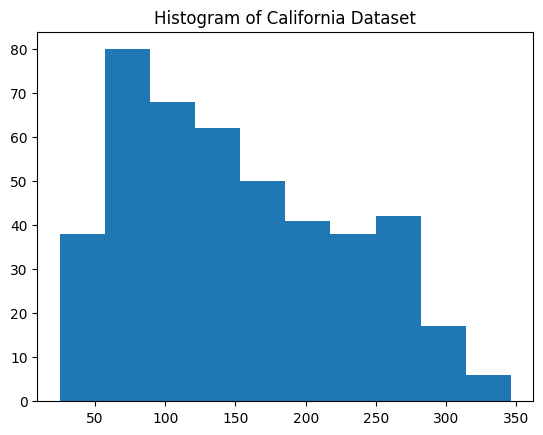

In [3]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)
X = pd.DataFrame(X)
y = pd.Series(y, name="output")


# looking at target distribution
_ = plt.hist(y)
plt.title("Histogram of California Dataset")

Starting with linear regression, fitting a linear regression through the `mcglm` library is plain. The picks are `identity` as a link, `constant` as variance, and an `identity matrix` as Z.

In [4]:
modelresults = MCGLM(endog=y, 
                     exog=X, 
                     z=[mc_id(X)]
                     ).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                 output   No. Iterations:                      1
Model:                          MCGLM   No. Observations:                  442
link:                        identity   Df Residuals:                      431
variance:                    constant   Df Model:                           11
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 21 Dec 2023   pAIC                           5327.73
Time:                        09:25:25   pBIC                           5372.73
                                        pLogLik                     -2652.8628
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0            -10.0099    177.919     -0.056      0.955    -358.725     338.705
1           -239.8156    182.306     -1.315      0.188    -597.128     117.497
2            519.8459    198.121      2.624      0.009     131.536     908.156
3            324.3846    194.811      1.665      0.096     -57.438     706.208
4           -792.1756   1240.774     -0.638      0.523   -3224.047    1639.696
5            476.7390   1009.552      0.472      0.637   -1501.947    2455.425
6            101.0433    632.868      0.160      0.873   -1139.356    1341.442
7            177.0632    480.837      0.368      0.713    -765.359    1119.486
8            751.2737    511.877      1.468      0.142    -251.987    1754.535
9             67.6267    196.486      0.344      0.731    -317.478     452.731
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1    2.6e+04    796.484     32.649      0.000    2.44e+04    2.76e+04
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

The residual analysis is key for assessing the fulfillment of the assumptions. For more details, check out (Montgomery. D.C and Runger. G.C, 2013).

Text(0, 0.5, 'pearson residuals')

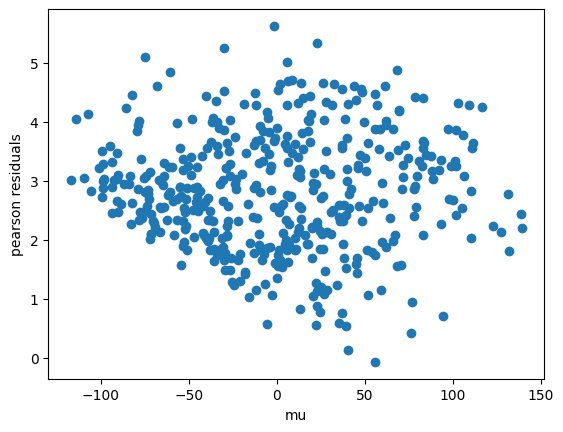

In [5]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

As long as the Pearson residuals aren't shapeless, they may point to a non-optimal fitting.

##### 2. A count analysis

This dataset hosts information from a Canadian study of mortality by age and smoking status. https://data.princeton.edu/wws509/datasets/#smoking. The four-column dataset establishes features: age, smoking status, population, and the outcome of deaths. 

Linear regression is unsuitable for analyzing discrete count data, and a Poisson model is a usual choice. With `mcglm` is easy to leverage the Poisson Model.

In [6]:
smoking_data = pd.read_csv("data/smoking_data.csv")

## exog and endog
X = dmatrix("~ pop + age + smoke", smoking_data, return_type="dataframe")
y = smoking_data["dead"]

Text(0.5, 1.0, 'Histogram of absolute count of deads')

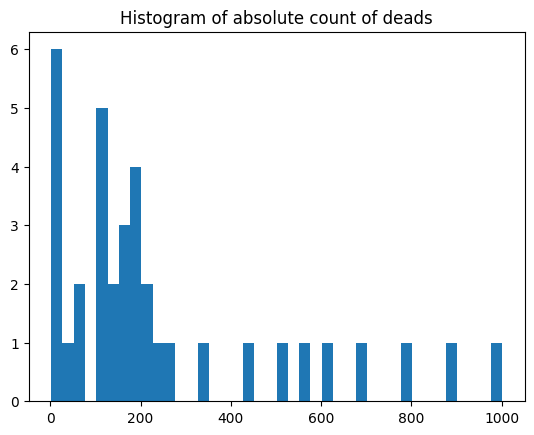

In [7]:
_ = plt.hist(y, bins=40)
plt.title("Histogram of absolute count of deads")

That is a long-tail distribution.   

Straight off the bat, we attempt fitting as a linear regression: `identity` and `constant`.  

In [8]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                   dead   No. Iterations:                      1
Model:                          MCGLM   No. Observations:                   36
link:                        identity   Df Residuals:                       22
variance:                    constant   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 21 Dec 2023   pAIC                            429.44
Time:                        09:25:27   pBIC                            451.61
                                        pLogLik                       -200.719
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -224.6373     66.931     -3.356      0.001    -355.820     -93.455
age[T.45-59]                 95.3834     76.446      1.248      0.212     -54.448     245.215
age[T.50-54]                147.8634     78.491      1.884      0.060      -5.977     301.703
age[T.55-59]                216.4651     74.395      2.910      0.004      70.654     362.276
age[T.60-64]                344.0038     76.451      4.500      0.000     194.162     493.846
age[T.65-69]                426.7793     74.466      5.731      0.000     280.829     572.730
age[T.70-74]                399.1722     78.027      5.116      0.000     246.242     552.103
age[T.75-79]                335.9303     83.318      4.032      0.000     172.629     499.231
age[T.80+]                  293.7420     86.312      3.403      0.001     124.573     462.911
smoke[T.2.cigarPipeOnly]     32.3389     49.616      0.652      0.515     -64.906     129.584
smoke[T.3.cigarrettePlus]    85.2001     76.811      1.109      0.267     -65.347     235.747
smoke[T.4.cigarretteOnly]    87.8965     60.879      1.444      0.149     -31.425     207.218
pop                           0.1128      0.023      4.814      0.000       0.067       0.159
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1  1.107e+04   1899.730      5.825      0.000    7342.638    1.48e+04
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

Let's try a `Tweedie` with a power set as one, as a `Poisson` model. As mentioned, Poisson is a suitable pick for modeling count data.

In [9]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
    link="log",
    variance="tweedie",
    power=1,
    power_fixed=True,
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                   dead   No. Iterations:                      1
Model:                          MCGLM   No. Observations:                   36
link:                             log   Df Residuals:                       22
variance:                     tweedie   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 21 Dec 2023   pAIC                            371.22
Time:                        09:25:27   pBIC                            393.39
                                        pLogLik                      -171.6087
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.5604      0.283      9.056      0.000       2.006       3.115
age[T.45-59]                  0.6242      0.310      2.011      0.044       0.016       1.233
age[T.50-54]                  1.0038      0.308      3.261      0.001       0.401       1.607
age[T.55-59]                  1.3818      0.245      5.635      0.000       0.901       1.862
age[T.60-64]                  1.5012      0.245      6.133      0.000       1.021       1.981
age[T.65-69]                  2.1366      0.240      8.920      0.000       1.667       2.606
age[T.70-74]                  2.3557      0.269      8.766      0.000       1.829       2.882
age[T.75-79]                  2.2041      0.298      7.403      0.000       1.621       2.788
age[T.80+]                    1.9506      0.318      6.143      0.000       1.328       2.573
smoke[T.2.cigarPipeOnly]      0.2114      0.176      1.203      0.229      -0.133       0.556
smoke[T.3.cigarrettePlus]     0.5030      0.214      2.347      0.019       0.083       0.923
smoke[T.4.cigarretteOnly]     0.7818      0.164      4.755      0.000       0.460       1.104
pop                           0.0004   6.25e-05      6.679      0.000       0.000       0.001
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1    14.1200      3.786      3.729      0.000       6.699      21.541
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

Text(0, 0.5, 'pearson residuals')

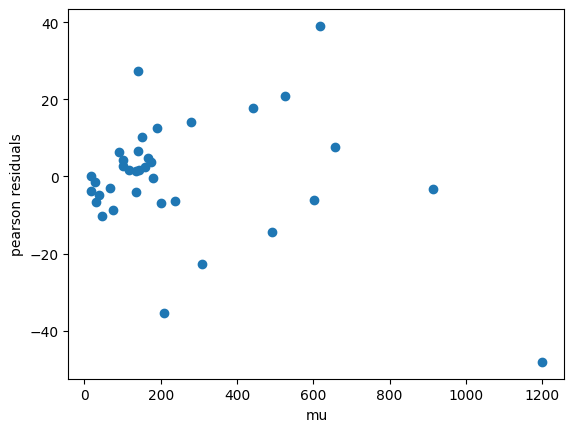

In [10]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

By the `pAIC` metric, the usual `Tweedie` variance function is a suitable pick.


------

It is plain to harness an essential trait of the `mcglm` library, the power estimation for a `Poisson Tweedie` fitting. We have got to set the parameter power_fixed as `False`. 

In [11]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
    link="log",
    variance="poisson_tweedie",
    power=1,
    power_fixed=False,
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                   dead   No. Iterations:                     12
Model:                          MCGLM   No. Observations:                   36
link:                             log   Df Residuals:                       22
variance:             poisson_tweedie   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                     False
Date:                Thu, 21 Dec 2023   pAIC                            370.17
Time:                        09:25:28   pBIC                            392.34
                                        pLogLik                      -171.0843
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.4466      0.269      9.094      0.000       1.919       2.974
age[T.45-59]                  0.6573      0.297      2.209      0.027       0.074       1.240
age[T.50-54]                  1.0419      0.298      3.498      0.000       0.458       1.626
age[T.55-59]                  1.3900      0.244      5.703      0.000       0.912       1.868
age[T.60-64]                  1.5253      0.242      6.300      0.000       1.051       2.000
age[T.65-69]                  2.1935      0.236      9.283      0.000       1.730       2.657
age[T.70-74]                  2.4571      0.263      9.350      0.000       1.942       2.972
age[T.75-79]                  2.3416      0.290      8.082      0.000       1.774       2.909
age[T.80+]                    2.1177      0.307      6.906      0.000       1.517       2.719
smoke[T.2.cigarPipeOnly]      0.1685      0.172      0.980      0.327      -0.168       0.505
smoke[T.3.cigarrettePlus]     0.4427      0.217      2.041      0.041       0.017       0.868
smoke[T.4.cigarretteOnly]     0.7345      0.167      4.398      0.000       0.407       1.062
pop                           0.0005    6.4e-05      7.110      0.000       0.000       0.001
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     3.0590      3.121      0.980      0.327      -3.059       9.177
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.2895      0.198      6.526      0.000       0.902       1.677
==============================================================================
"""

By the `pAIC`, the adjustment with `Poisson Tweedie` power set 1.263 is lightly better than `Poisson` 1. It points out that the distribution `Poisson Tweedie` is the best option for this data learning.

##### 3. A bounded analysis


For a bound analysis, we analyze the iconic titanic dataset.

In [12]:
titanic = pd.read_csv("data/titanic.csv")

y = titanic["Survived"]

X = titanic[["Fare", "SibSp", "Embarked", "Parch", "Pclass"]]
X = X.fillna("S")

X = dmatrix("~ Fare + SibSp + Embarked + Parch + Pclass", X, return_type="dataframe")

modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
    link="logit",
    variance="binomialP",
    ntrial=1,
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:               Survived   No. Iterations:                      1
Model:                          MCGLM   No. Observations:                  891
link:                           logit   Df Residuals:                      883
variance:                   binomialP   Df Model:                            8
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 21 Dec 2023   pAIC                            212.54
Time:                        09:25:31   pBIC                            250.88
                                        pLogLik                       -98.2698
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4120      0.343      4.122      0.000       0.741       2.083
Embarked[T.Q]     0.2911      0.307      0.949      0.343      -0.310       0.893
Embarked[T.S]    -0.5179      0.196     -2.636      0.008      -0.903      -0.133
Fare              0.0037      0.002      1.554      0.120      -0.001       0.008
SibSp            -0.1274      0.082     -1.561      0.119      -0.287       0.033
Parch             0.2920      0.101      2.906      0.004       0.095       0.489
Pclass           -0.7556      0.116     -6.508      0.000      -0.983      -0.528
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     0.9990      0.036     27.961      0.000       0.929       1.069
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

In [13]:
## Evaluating multiple links
modelresults_logit = MCGLM(
    y, X, [mc_id(X)], link="logit", variance="binomialP", ntrial=1
).fit()

modelresults_loglog = MCGLM(
    y, X, [mc_id(X)], link="loglog", variance="binomialP", ntrial=1
).fit()

modelresults_cloglog = MCGLM(
    y, X, [mc_id(X)], link="cloglog", variance="binomialP", ntrial=1
).fit()

modelresults_cauchy = MCGLM(
    y, X, [mc_id(X)], link="cauchy", variance="binomialP", ntrial=1
).fit()

In [14]:
print(
    "logit_aic: ",
    modelresults_logit.aic,
    ", loglog_aic: ",
    modelresults_loglog.aic,
    ", cloglog_aic: ",
    modelresults_cloglog.aic,
    ", cauchy_aic: ",
    modelresults_cauchy.aic,
)

logit_aic:  212.54 , loglog_aic:  202.04 , cloglog_aic:  222.58 , cauchy_aic:  216.94


The loglog link is the best pick for this analysis.    

In addition, the `mcglm` can fit response variables when its realizations are non-independent.


### Non-independent section

Let's leverage the `mcglm` to adjust non-independent data, illustrated by a Moving Average and Mixed Model analysis, two iconic statistical models.

##### 1. Moving Average model 

In MA model, the current realization is linearly dependent of past error terms. The script below defines a MA realization of size 1, and `q` defined as `0.4`. 

Text(0, 0.5, '$y$')

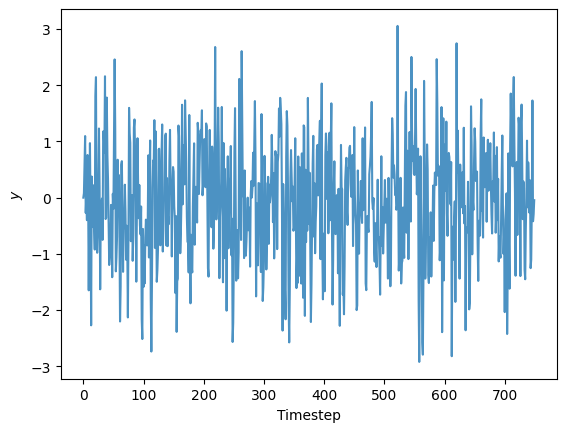

In [15]:
SAMPLE_SIZE = 750
RANDOM_SEED = 42
y = np.zeros((SAMPLE_SIZE,))


# true stationarity
true_theta = 0.4
# true standard deviation of the innovation:
true_sigma = 1
# true process mean:
true_center = 0.0

innovations = np.random.normal(true_center, true_sigma, SAMPLE_SIZE)

for t in range(1, SAMPLE_SIZE):
    y[t] = innovations[t] + true_theta * innovations[t-1]

plt.plot(y, alpha=0.8)
plt.xlabel("Timestep")
plt.ylabel("$y$")

In [16]:
# building covariance matrix and outcome vector.
data = pd.DataFrame()
data["ma_sample"] = y
data["index"] = list(range(0, SAMPLE_SIZE))
data = add_constant(data)

X = data[["const"]]
y = data["ma_sample"]

To find the best size for MA, the `q` fitting, we benchmark them by `pAIC`. Moreover, the `mc_ma` assist us in building the Z matrices for the MA analysis.

In [17]:
one_order = [mc_id(X), mc_ma(id="const", time="index", data=data, order=1)]
two_order = [*one_order, mc_ma(id="const", time="index", data=data, order=2)]
three_order = [*two_order, mc_ma(id="const", time="index", data=data, order=3)]
four_order = [*three_order, mc_ma(id="const", time="index", data=data, order=4)]
five_order = [*four_order, mc_ma(id="const", time="index", data=data, order=5)]
six_order = [*five_order, mc_ma(id="const", time="index", data=data, order=6)]
seven_order = [*six_order, mc_ma(id="const", time="index", data=data, order=7)]

In [18]:
for index, order in enumerate(
    [one_order, two_order, three_order, four_order, five_order, six_order, seven_order]
):
    modelresults = MCGLM(y, X, order).fit()

    print("q value: ", str(index + 1), ", paic: ", modelresults.aic)

q value:  1 , paic:  1311.21
q value:  2 , paic:  1313.11
q value:  3 , paic:  1314.31
q value:  4 , paic:  1316.26
q value:  5 , paic:  1318.22
q value:  6 , paic:  1318.67
q value:  7 , paic:  1319.09


Displacement q as 1 as the best fit.

In [19]:
modelresults = MCGLM(y, X, one_order).fit()
modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:              ma_sample   No. Iterations:                      2
Model:                          MCGLM   No. Observations:                  750
link:                        identity   Df Residuals:                      747
variance:                    constant   Df Model:                            3
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 21 Dec 2023   pAIC                           1311.21
Time:                        09:27:23   pBIC                           1325.07
                                        pLogLik                       -652.606
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0793      0.048     -1.658      0.097      -0.173       0.014
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     1.0350      0.056     18.453      0.000       0.925       1.145
dispersion_2     0.3410      0.035      9.640      0.000       0.272       0.410
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

The summary report drills down the $\theta$ parameters that linearly operate the Gaussian White Noise, and 0.4, the actual value, falls within the interval of the second dispersion parameter.

##### 2. Random Effect models

The dataset `sleepstudy` is a study of sleep deprivation. https://www.rdocumentation.org/packages/lme4/versions/1.1-26/topics/sleepstudy. 

The study aims to understand the influence of sleep deprivation on reaction time. On day 0, subjects had their usual amount of sleep. From day 0 on, they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject.

One promising approach is fitting through two-level effect models, such as `mixed models`. The `mcglm` library is a perfect framework to apply this statistical learning; due to the model and the method `mc_mixed()` to build a dependence matrix.

In [20]:
# Top 10 cells to get an intuition about data.
sleepstudy = pd.read_csv(
    "data/first_simulation/sleepstudy.csv", dtype={"Subject": "str"}
)

sleepstudy.head(10)

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
5,414.6901,5,308
6,382.2038,6,308
7,290.1486,7,308
8,430.5853,8,308
9,466.3535,9,308


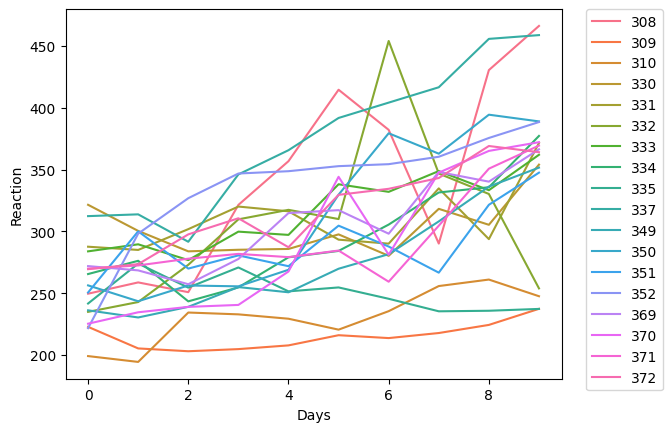

In [21]:
## Plotting curve of 18 subjects
_ = sns.lineplot(x="Days", y="Reaction", hue="Subject", data=sleepstudy)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [22]:
# Design Matrix
X = dmatrix("~ Days", sleepstudy, return_type="dataframe")

# Z specification
Z = [mc_id(sleepstudy)] + mc_mixed(formula="~ 0 + Subject / Days", data=sleepstudy)


# Model fitting
mcglm = MCGLM(endog=sleepstudy["Reaction"], exog=X, z=Z)

mcglmresults = mcglm.fit()

mcglmresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:               Reaction   No. Iterations:                      1
Model:                          MCGLM   No. Observations:                  180
link:                        identity   Df Residuals:                      174
variance:                    constant   Df Model:                            6
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 21 Dec 2023   pAIC                           1583.94
Time:                        09:27:25   pBIC                            1603.1
                                        pLogLik                      -785.9702
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    251.4051      6.632     37.906      0.000     238.406     264.404
Days          10.4673      1.502      6.968      0.000       7.523      13.412
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1   654.9410     70.624      9.274      0.000     516.521     793.361
dispersion_2   565.5150    264.679      2.137      0.033      46.753    1084.277
dispersion_3    32.6820     13.560      2.410      0.016       6.105      59.259
dispersion_4    11.0550     42.948      0.257      0.797     -73.121      95.231
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

* Regression coefficients  
The regression section diagnose the fixed-effects parameters, that is to say, the conclusion overall subjects.  

    Intercept set at value 251.40. The straightforward takeaway is: At day 0, the average response time is roughly 251 seconds.
    In addition, Days at 10.46 allude to total change to response time by unit changes on Days, for subjects with random effects set to 0.
    Furthermore, by the results of the wald test on Days, we might conclude that days are statistically significant for the model.


* Dispersion parameters   
The dispersion parameters allude to random effects within individuals throughout the days.  

    The first dispersion parameter is the variance across all data points. Calculated in 654.94.
    The second dispersion parameter is the variance across all intercepts, which is 565.51.
    The third dispersion parameter is the variance across all slopes. Calculated in 32.68. 
    The fourth dispersion parameter is the variance across intercepts and slopes. Calculated in 11.05.

* Moreover, the correlation might be calculated through the formula = dispersion_4/sqrt(dispersion_2 * dispersion_3). Cell below shows the pearson correlation result, 0.0812.   

Furthermore, `mcglm` can also do multivariate analysis.


#### Multivariate Models

Soya

`Soya` is a dataset that stores an experiment of Universidade Federal da Grande Dourados in Dourados, Mato Grosso do Sul, Brazil. Description:    
https://github.com/walmes/wzRfun/blob/master/R/wzRfun.R#L10   
http://ccarevista.ufc.br/seer/index.php/ccarevista/article/view/1454  

The experiment collected data about different treatments of `potassium`, `water`, and `blocks` for soil farming on buckets. All of those covariates are categorical. The response traits to be analyzed are: `grain size`, `total seeds`, and `viable peas`, which stands for the weight of hundred grains, total grain per bucket, and percentage of viable peas(green beans). In the following, MCGLM fits onto this data with three unique answers: continuous, count, and binomial.

In [23]:
soya = pd.read_csv(
    "data/fourth_simulation/soya.csv",
    dtype={"block": "str", "water": "str", "pot": "str"},
)

# percentual of peas.
soya["viablePeas"] = soya["viablepeas"] / soya["totalpeas"]

# Design matrix.
X = dmatrix("~ block + water * pot", soya, return_type="dataframe")


# Model Specification
mcglm = MCGLM(
    endog=[soya["grain"], soya["seeds"], soya["viablePeas"]],
    exog=[X, X, X],
    z=[[mc_id(soya)], [mc_id(soya)], [mc_id(soya)]],
    link=["identity", "log", "logit"],
    variance=["constant", "tweedie", "binomialP"],
    ntrial=[None, None, soya["totalpeas"].values],
)


mcglmresults = mcglm.fit()

mcglmresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                  grain   No. Iterations:                      3
Model:                          MCGLM   No. Observations:                   75
link:                        identity   Df Residuals:                       55
variance:                    constant   Df Model:                           20
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 21 Dec 2023   pAIC                            448.02
Time:                        09:27:26   pBIC                            516.34
                                        pLogLik                      -204.0085
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   14.2455      1.217     11.701      0.000      11.859      16.632
block[T.II]                  1.1326      0.880      1.287      0.198      -0.593       2.858
block[T.III]                -0.7797      0.880     -0.886      0.376      -2.505       0.946
block[T.IV]                 -1.5495      0.880     -1.760      0.078      -3.275       0.176
block[T.V]                  -2.3866      0.880     -2.711      0.007      -4.112      -0.661
water[T.50]                  2.1660      1.531      1.415      0.157      -0.834       5.166
water[T.62.5]                2.5404      1.531      1.660      0.097      -0.460       5.541
pot[T.120]                  11.7898      1.531      7.702      0.000       8.790      14.790
pot[T.180]                  11.8633      1.531      7.750      0.000       8.863      14.864
pot[T.30]                    6.7894      1.531      4.435      0.000       3.789       9.790
pot[T.60]                   10.3978      1.531      6.793      0.000       7.398      13.398
water[T.50]:pot[T.120]       2.2541      2.165      1.041      0.298      -1.989       6.497
water[T.62.5]:pot[T.120]     5.5826      2.165      2.579      0.010       1.340       9.826
water[T.50]:pot[T.180]       1.2097      2.165      0.559      0.576      -3.033       5.453
water[T.62.5]:pot[T.180]     9.2391      2.165      4.268      0.000       4.996      13.482
water[T.50]:pot[T.30]        0.1069      2.165      0.049      0.961      -4.136       4.350
water[T.62.5]:pot[T.30]     -1.8677      2.165     -0.863      0.388      -6.111       2.375
water[T.50]:pot[T.60]        2.6035      2.165      1.203      0.229      -1.640       6.847
water[T.62.5]:pot[T.60]      3.3585      2.165      1.551      0.121      -0.885       7.602
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     5.8610      1.671      3.507      0.000       2.586       9.136
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                  seeds   No. Iterations:                      3
Model:                          MCGLM   No. Observations:                   75
link:                             log   Df Residuals:                       55
variance:                     tweedie   Df Model:                           20
Me

The three responses have generated a three-section report, an analysis per response.


`grain` size.

The grain response was fitted with default parameters, `identity` and `constant`, generating a near homoscedastic linear model. Among covariates `block`, `water` and `potassium`, by Wald test, potassium levels are statistically significant for the model; the higher the potassium level, the bigger grain size. Variance is constant on 5.862.  

Residual analysis:

Text(0, 0.5, 'pearson residuals')

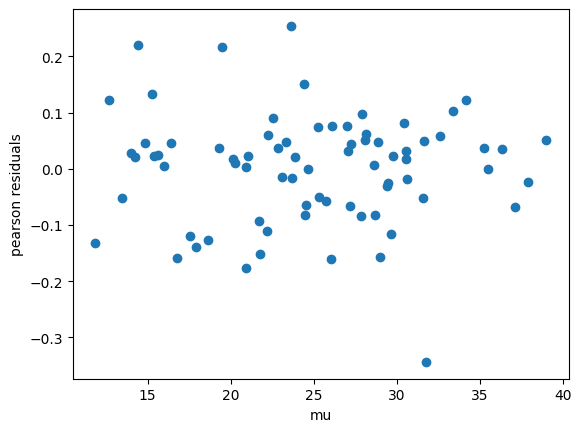

In [24]:
# grain. residual analysis
plt.scatter(mcglmresults.mu[0], mcglmresults.pearson_residuals[0])
plt.xlabel("mu")
plt.ylabel("pearson residuals")

The fitting looks good.


`seed` count.


As long as `seed` is a count variable, a straightforward and canonical way to model it is Poisson. Out of three, two covariates are statistically significant on `seed`: potassium for every level; and black for level V.

Residual analysis:

Text(0, 0.5, 'pearson residuals')

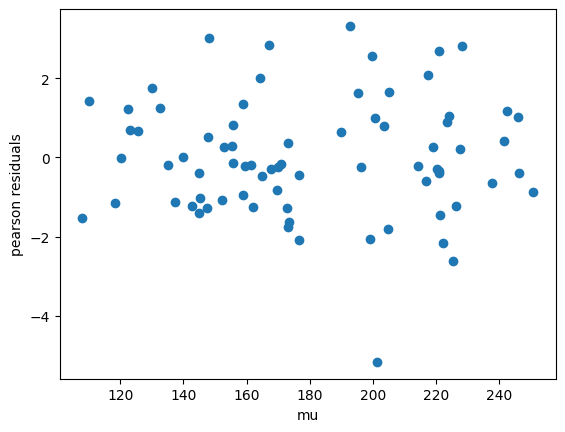

In [25]:
# seeds. residual analysis
plt.scatter(mcglmresults.mu[1], mcglmresults.pearson_residuals[1])
plt.xlabel("mu")
plt.ylabel("pearson residuals")

The fitting seems good.

Percentage of `viable peas`.

Binomial N trials are the adequate model for bounded data. Perhaps, the most popular solution to fit is the `Logit` link, the one used. Among covariates, only potassium level 30, and water level 50 are statistically significant with Viable Peas.

Residual Analysis:

Text(0, 0.5, 'pearson residuals')

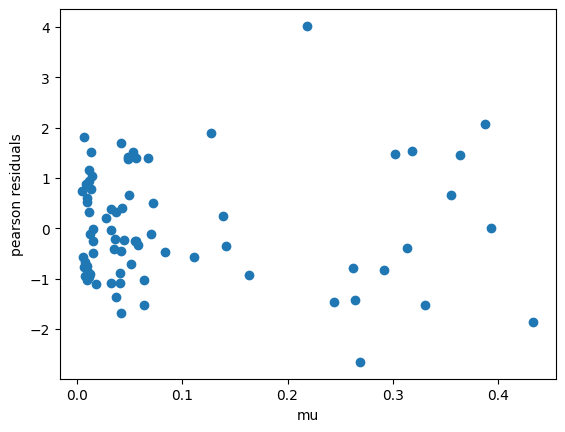

In [26]:
# viablepeasP. residual analysis
plt.scatter(mcglmresults.mu[2], mcglmresults.pearson_residuals[2])
plt.xlabel("mu")
plt.ylabel("pearson residuals")

The last three components' rhos allude to the correlation coefficient among responses. 
 * rho_1 stands for grain size and whole seeds, with a considerable Pearson correlation of 0.63.
 * rho_2 and rho_3 dispersion parameters represent the correlation between grain size and viable peas, seed count, and viable peas, respectively. Both correlations are low. 

Do not hesitate to leverage `mcglm` on your analysis and leave feedback. Thanks.

------------------
References

[1] Stigler SM (1981). “Gauss and the Invention of Least Squares.” The Annals of Statistics, 9(3), 465 – 474. doi:10.1214/aos/1176345451. URL https://doi.org/10.1214/aos/1176345451   
[2] Hallin M (2014). Gauss–Markov Theorem in Statistics. ISBN 9781118445112. doi:10.1002/9781118445112.stat07536.   
[3] Narula SC, Wellington JF (1982). “The Minimum Sum of Absolute Errors Regression: A State of the Art Survey.”    
[4] Galton F (1886). “Regression towards mediocrity in hereditary stature.” Journal of the Anthropological Institute of Great Britain and Ireland, pp. 246–263.   
[5] Seal HL (1967). “Studies in the History of Probability and Statistics. XV: The Historical Development of the Gauss Linear Model.” Biometrika, 54(1/2), 1–24. ISSN 00063444. URL http://www.jstor.org/stable/2333849.   
[6] Nelder J, Wedderburn R (1972). “Generalized Linear Models.” pp. 370–384. doi:https://doi.org/10.2307/2344614.   
[7] M ̈uller M (2004). “Generalized Linear Models.” doi:10.1007/978-3-642-21551-3_24.   
[8] Hastie T, Tibshirani R (1986). “Generalized additive models (with discussion).” Statistical Science 1, p. 297–318.       
[9] Liang KY, Zeger SL (1986). “Longitudinal Data Analysis Using Generalized Linear Models.” Biometrika, 73(1), 13–22.   
[10] Krupskii P, Joe H (2013). “Factor Copula Models for Multivariate Data.” Journal of Multivariate Analysis, 120(1), 85–101.   
[11] Masarotto G, Varin C (2012). “Gaussian Copula Marginal Regression.” Electronic Journal of Statistics, 6, 1517–1549.    
[12] Verbeke G, Fieuws S, Molenberghs G, Davidian M (2014). “The Analysis of Multivariate Longitudinal Data: A Review.” Statistical Methods in Medical Research, 23(1), 42–59.   
[13] Bonat WH, Jørgensen B (2016). “Multivariate Covariance Generalized Linear Models.” Journal of the Royal Statistical Society C, 65(5), 649–675. doi:10.1111/rssc.12145.
[14] Jennrich RI (1969). “A Newton-Raphson algorithm for maximum likelihood factor analysis.” Psychometrika, 34. ISSN 1860-0980. doi:10.1093/biomet/61.3.439. URL https://doi.org/10.1007/BF02290176.   
[15] Widyaningsih P, Saputro D, Putri A (2017). “Fisher Scoring Method for Parameter Estimation of Geographically Weighted Ordinal Logistic Regression (GWOLR) Model.” Journal of Physics: Conference Series, 855, 012060. doi:10.1088/1742-6596/855/1/012060   
[16] Jørgensen B, Knudsen SJ (2004). “Parameter Orthogonality and Bias Adjustment for Estimating Functions.” Scandinavian Journal of Statistics, 31(1), 93–114.   
[17] Wedderburn RWM (1974). “Quasi likelihood functions, generalized linear models, and the Gauss—Newton method.” Biometrika, 61(3), 439–447. ISSN 0006-3444. doi:10.1093/biomet/61.3.439. https://academic.oup.com/biomet/article-pdf/61/3/439/690500/61-3-439.pdf, URL https://doi.org/10.1093/biomet/61.3.439.     
[18] Martinez-Beneito MA (2013). “A General Modelling Framework for Multivariate Disease Mapping.” Biometrika, 100(3), 539–553.   
[19] Anderson TW (1973). “Asymptotically Efficient Estimation of Covariance Matrices with Linear Structure.” The Annals of Statistics, 1(1), 135–141.   
[20] Pourahmadi M (2000). “Maximum Likelihood Estimation of Generalized Linear Models for Multivariate Normal Covariance Matrix.” Biometrika, 87(2), 425–435.   
[21] Bonat WH (2016). “Modelling Mixed Outcomes in Additive Genetic Models.” ArXiv.    
[22] Chiu TYM Leonard T TK (1996). “The Matrix-Logarithmic Covariance Model.” Journal of the American Statistical Association. doi:10.1080/01621459.1996.10476677.     
[23] Jørgensen B (1987). “Exponential dispersion models.” Journal of the Royal Statistical Society.    
[24] Jørgensen B (1997). “The theory of dispersion models.” CRC Press.    
[25] Jørgensen B, Kokonendji CC (2015). “Discrete dispersion models and their tweedie asymptotics.” AStA Advances in Statistical Analysis, 100(1), p. 43–78.   
